In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.interpolate import splrep, splev
import matplotlib.patches as mpatches
from scipy.signal import savgol_filter

# Processing Excel files to a pandas dataframe

Can also save the dataframe as a .csv file - set save to True

Works same way for bio files - just have to use process_bio from the GitHub instead

In [0]:
def process_land(directory, file, save=False, savedirectory=None, remove_short_cycles=True, remove_cv=True,
                 file_check_dict=None, mass=None, plot=True):
    """
    Function to read and process land EC data files exported landdt, returns a pandas dataframe of
    the relevant data. Can also save this dataframe as a csv file in the directory of your choice. Additionally certain
    filters can be toggled and a dictionary can be supplied to record anomalous cycles that may require more close
    analysis.
    Note if you don't supply a mass, the function will look for a column called SCapacity/mAh/g in the export
    - if neither are here it will not give specific capacity information
    :param savedirectory: Directory to save .csv file to if desired
    :param file: .xlsx or .xlx file to read from Landdt
    :param save: If .csv file is to be saved - True, else False, default False
    :param directory: Directory to read .mpt or .txt file from - end in '/'
    :param remove_short_cycles: If you want to delete cycles < 10 data points - not really a full cycle but sometimes appear
                                default = True
    :param remove_cv: Remove constant voltage cycles - default =True
    :param file_check_dict: If you want to have a check dictionary -
                            to save any weird results that might need more checking
    :param mass If you want to input a manual mass to overide what is in the file header - units = grams
    :return:
    """
    # Loading in the file and stitching together the multiple excel sheets if there are any
    xlsx = pd.ExcelFile(directory + file)
    names = xlsx.sheet_names

    data_sheets = [xlsx.parse(0)]
    # Finding all sheets with Record in after the first
    for sheet_name in names[1:]:
        if "Record" in sheet_name:
            if len(xlsx.parse(sheet_name, header=None)) != 0:
                data_sheets.append(xlsx.parse(sheet_name, header=None))

    # fixing columns for subsequent data sheets (no header for these in input file
    for sheet in data_sheets:
        sheet.columns = data_sheets[0].columns
    df = pd.concat(data_sheets)
    df.set_index('Index', inplace=True)

    # Removing any mode rest data so it doesn't come up as the first cycle
    df = df[df['Current/mA'] != 0.0]

    # If the state is not exported try to infer from sign of current
    def state_func(x):
        if x > 0:
            return 'Charge'
        elif x < 0:
            return 'Discharge'
        else:
            raise ValueError('Current = 0.0 - cannot decide if charge or discharge')

    if 'State' not in [i for i in df.columns]:
        df['State'] = df['Current/mA'].apply(state_func)

    df['Cycle'] = df['State'].ne(df['State'].shift()).cumsum()
    # Optionally removing small cycles - won't count them for cycle num etc - removes some anomalous cycles
    if remove_short_cycles:
        for cycle in df['Cycle'].unique():
            if len(df[df['Cycle'] == cycle]) < 10:
                df = df[df['Cycle'] != cycle]

    df['Cycle'] = df['State'].ne(df['State'].shift()).cumsum()

    # Optionally removing CV - won't recount cycles

    if remove_cv:
        df = df[df['State'] != 'D_CV']
        df = df[df['State'] != 'C_CV']

    # if len(df[df['State'] == 'C_CV']) > 5:
    #     df = df
    # else:
    #     df = df[df['State'] != 'D_CV']
    #     df = df[df['State'] != 'C_CV']
    #     df['Cycle'] = df['State'].ne(df['State'].shift()).cumsum()

    # Escape if the filters remove every cycle - i.e if all are rest or CV and these are specified to be removed
    if len(df) == 0:
        print(f'{file} no cycles remaining after filters')
        return

    # Optional file check functionality - will return the supplied dictionary with the cycles that may be anomalous
    if file_check_dict is not None:
        for cyclenum, cycledata in df.groupby('Cycle'):
            # print('Cycle {} length {}'.format(cyclenum, len(cycledata['Cycle'])))
            if len(cycledata['Cycle']) < 100:
                file_check_dict.setdefault(file, [[], []])
                file_check_dict[file][0].append(cyclenum)
        dv_dict = {cyclenum:
                       np.array(df[df['Cycle'] == cyclenum]['Voltage/V'])[-1]
                       - np.array(df[df['Cycle'] == cyclenum]['Voltage/V'])[0]
                   for cyclenum in df['Cycle'].unique()}

        for cycle in list(range(2, int(df['Cycle'].max() + 1), 2)):
            if dv_dict[cycle] < 0:
                file_check_dict.setdefault(file, [[], []])
                file_check_dict[file][1].append(cycle)
        for cycle in list(range(1, int(df['Cycle'].max() + 1), 2)):
            if dv_dict[cycle] > 0:
                file_check_dict.setdefault(file, [[], []])
                file_check_dict[file][1].append(cycle)

    # Setting up and populating the export dataframe - will have same columns as the bio export function
    dataframe = pd.DataFrame()
    dataframe['Cycle'] = df['Cycle']
    dataframe['Full Cycle'] = np.ceil(df['Cycle']/2).apply(int)
    dataframe['Machine'] = 'land'
    dataframe['Mode'] = df['State']
    dataframe['Current/mA'] = df['Current/mA']
    dataframe['Voltage/V'] = df['Voltage/V']
    dataframe['Capacity/mAh'] = df['Capacity/mAh']

    if mass is not None:
        dataframe['SCapacity/mAh/g'] = dataframe['Capacity/mAh'] / mass

    elif 'SCapacity/mAh/g' in [i for i in df.columns]:
        dataframe['SCapacity/mAh/g'] = df['SCapacity/mAh/g']
    else:
        print(f'{file} - WARNING, no mass supplied and no SCapacity exported - no SCapacity will be processed')

    filename = file.split('.')[0]

    if save:
        dataframe.to_csv(savedirectory + '{}.csv'.format(filename))

    if plot:
        for cycle in df['Cycle'].unique():
            plt.plot(df[df['Cycle'] == cycle]['Capacity/mAh'], df[df['Cycle'] == cycle]['Voltage/V'])
        plt.xlabel('Capacity/mAh')
        plt.ylabel('Voltage/V')
        plt.show()
        plt.close()

    return dataframe

NJK_CC_88.xls - WARNING, no mass supplied and no SCapacity exported - no SCapacity will be processed


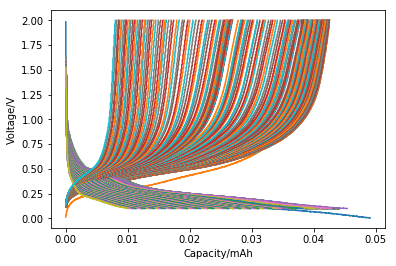

In [50]:
DIRECTORY = 'Nis_excel2/'
sample = 'NJK_CC_88.xls'

df = process_land(DIRECTORY, sample, plot=True)

## Manipulating dataframe and plotting cycles

Now the data is in a pandas dataframe it's easy to manipulate and plot what you want:

In [51]:
df.head()

,Cycle,Full Cycle,Machine,Mode,Current/mA,Voltage/V,Capacity/mAh
Index,,,,,,,
1202,1,1,land,D_CC,-0.0024,1.9860,0.0
1203,1,1,land,D_CC,-0.0024,1.9860,0.0
1204,1,1,land,D_CC,-0.0025,1.9860,0.0
1205,1,1,land,D_CC,-0.0025,1.9038,0.0
1206,1,1,land,D_CC,-0.0025,1.8347,0.0


Selecting a cycle - showing first 5 lines of cycle 4

In [63]:
cycle = 4
df[df['Full Cycle'] == cycle].head()

,Cycle,Full Cycle,Machine,Mode,Current/mA,Voltage/V,Capacity/mAh
Index,,,,,,,
41221,7,4,land,D_CC,-0.0084,1.5082,0.0
41222,7,4,land,D_CC,-0.0084,1.5082,0.0
41223,7,4,land,D_CC,-0.0084,1.5082,0.0
41224,7,4,land,D_CC,-0.0084,1.4373,0.0
41225,7,4,land,D_CC,-0.0084,1.3799,0.0


Plotting a cycle 

Note 'Cycle' column is half cycles, 'Full Cycle' is full cycles

Text(0, 0.5, 'Voltage/V')

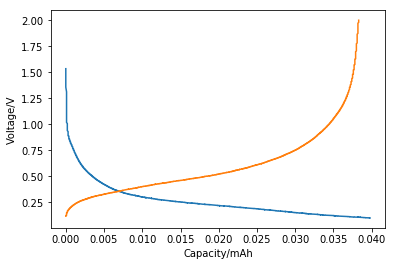

In [68]:

cycles = [3, 4]
for cycle in cycles:
    capacity = df[df['Cycle'] == cycle]['Capacity/mAh']
    voltage = df[df['Cycle'] == cycle]['Voltage/V']
    plt.plot(capacity, voltage)

plt.xlabel('Capacity/mAh')
plt.ylabel('Voltage/V')

Plotting capacity against cycle number

Text(0.5, 0, 'Cycle')

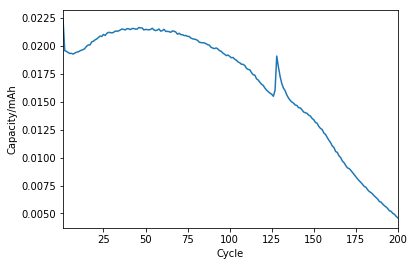

In [59]:
df.groupby('Full Cycle')['Capacity/mAh'].mean().plot()
plt.ylabel('Capacity/mAh')
plt.xlabel('Cycle')

More fancy plots of the cycling data

Text(0, 0.5, 'Voltage/V')

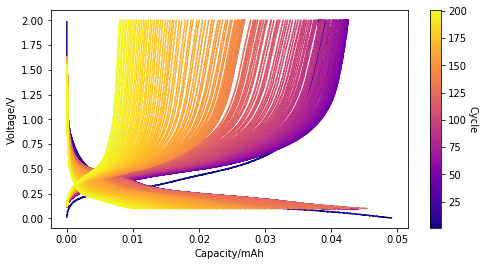

In [61]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cm = plt.get_cmap('plasma')
norm = Normalize(vmin=(min(df['Cycle'])+1)/2, vmax=(max(df['Cycle'])+1)/2)
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
plt.figure(figsize=(8,4))
for cycle in df['Cycle'].unique():
    plt.plot(df[df['Cycle'] == cycle]['Capacity/mAh'], df[df['Cycle'] == cycle]['Voltage/V'], color=cm(norm((cycle+1)/2)))

# fake up the array of the scalar mappable. Urgh...
sm._A = []

cbar = plt.colorbar(sm)
cbar.set_label(f'Cycle', rotation=270, labelpad=10)
plt.xlabel('Capacity/mAh')
plt.ylabel('Voltage/V')

# dQdV plotting

Here is the function - you need to supply the voltage in ascending order!

things to change here are the savgol smoothing coefficients

In [0]:
def dqdv_plotting(capacity, voltage, window_size=201, polyorder=5, smoothing=1e-6):

    # Literal spline - functionalising  voltage as a function of capacity - perfectly fit to every data point,
    # linearly interpolating between each point
    f_lit = splrep(capacity, voltage, s=0.0, k=1)

    lin_cap = np.linspace(min(capacity), max(capacity), num=1000)
    lin_volt = splev(lin_cap, f_lit)

    # Smoothing the set length linear voltage
    smooth_v = savgol_filter(lin_volt, window_size, polyorder, mode='interp')

    # Making sure voltage runs from low to high so splines work - no dV < 0  - after smoothing
    smooth_df = pd.DataFrame({'Voltage': smooth_v, 'Capacity': lin_cap})
    smooth_df.sort_values('Voltage', inplace=True)
    smooth_df['dV'] = smooth_df['Voltage'].diff()
    smooth_df.drop(smooth_df[smooth_df['dV'] < 0].index, inplace=True)

    # Final smooth voltage and capacity values - will be the same length, possiblt less than 1000
    smooth_v = smooth_df['Voltage']
    x_cap = smooth_df['Capacity']

    if sum(np.diff(smooth_v)) < 0:
        f = splrep(np.flip(smooth_v, axis=0), np.flip(x_cap, axis=0), s=smoothing, k=3)
    else:
        f = splrep(smooth_v, x_cap, s=smoothing, k=3)

    # x = voltage, y = dQ/dV
    x = np.linspace(voltage.min(), voltage.max(), 1000)
    y = abs(splev(x, f, der=1))

    spline_cap = abs(splev(x, f))
    
    smooth_dqdv = savgol_filter(y, 201, 5)
    return x, y, smooth_dqdv, spline_cap

## Populating a dictionary containing the data

How you get the raw capacity and voltage data is up to you, I can also send you my processing functions for land or bio data if you like - the pandas groupby method here is nice as it means there are no duplicate values - i.e one voltage having two different capacity values - this will break the spline fitting.

I think you also need to have the voltage going from low to high, but I have built in some catches for that in the function

Important value to play with here is smoothing value, currently 1e-6 to vary the closeness of the fit.

In the function you also have the parameters for the savgol filter on line 11 - may also be worth fiddling with these depending on your data. I'm happy to demo how it works if you would like!

In [0]:
voltage_range = [0.0, 0.8]
check_dict = {}
sample = 'NJK_CC_88.csv'
DIRECTORY = 'Nis_csv/Nis_processed'

plot_dict = {}

# df = pd.read_csv(f'{DIRECTORY}/{sample}', index_col=0)
for cycle in [3, 253, 255, 257, 259]:
    cycle_dict = {}
    df_cycle = df[df['Cycle'] == cycle]
    mask_max = df_cycle['Voltage/V'] < max(voltage_range)
    mask_min = df_cycle['Voltage/V'] > min(voltage_range)
    df_cycle = df_cycle[mask_max & mask_min]
    if len(df_cycle) < 50:
        pass
    df_cycle = df_cycle.groupby('Voltage/V', as_index=False)['Capacity/mAh'].mean()
    df_cycle = df_cycle.groupby('Capacity/mAh', as_index=False)['Voltage/V'].mean()

    voltage, dqdv, smoothed_dqdv, cap = dqdv_plotting(df_cycle['Capacity/mAh'], 
                                                      df_cycle['Voltage/V'], 
                                                      window_size=201,
                                                      polyorder=5,
                                                      smoothing=1e-6)

    cycle_dict['Voltage'] = voltage
    cycle_dict['Capacity'] = cap
    cycle_dict['dqdv'] = dqdv
    cycle_dict['Smoothed dqdv'] = smoothed_dqdv
    cycle_dict['Raw Voltage'] = df_cycle['Voltage/V']
    cycle_dict['Raw Capacity'] = df_cycle['Capacity/mAh']
    plot_dict.update({cycle:cycle_dict})

## How to compare the spline to the raw data

Text(0.5, 0, 'Capacity / mAh')

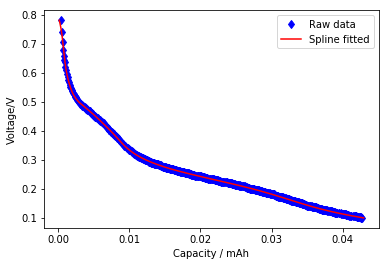

In [29]:
for cycle in [129*2-1]:
    plt.plot(plot_dict[cycle]['Raw Capacity'], plot_dict[cycle]['Raw Voltage'], 'bd', label='Raw data')
    plt.plot(plot_dict[cycle]['Capacity'], plot_dict[cycle]['Voltage'], 'r', label='Spline fitted')
    
plt.legend()
plt.ylabel('Voltage/V')
plt.xlabel('Capacity / mAh')

## Plotting different cycles same axis

Text(0.5, 0, 'Capacity / mAh')

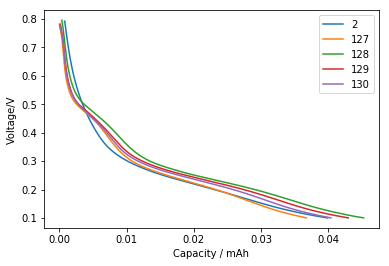

In [30]:
for cycle in plot_dict.keys():
    plt.plot(plot_dict[cycle]['Capacity'], plot_dict[cycle]['Voltage'], label=int((cycle+1)/2))
    
plt.legend()
plt.ylabel('Voltage/V')
plt.xlabel('Capacity / mAh')

## Plotting dQdV

Text(0, 0.5, 'dQdV / mAh/V')

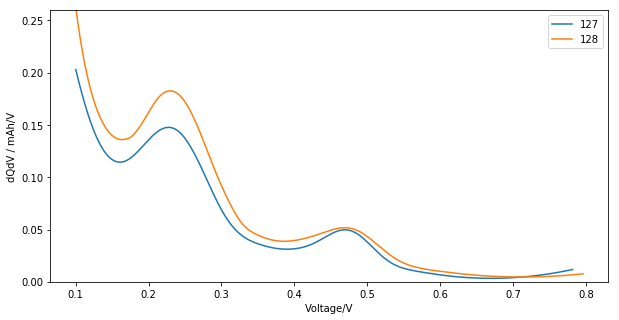

In [31]:
plt.figure(figsize=(10,5))
for cycle in [i*2-1 for i in [127, 128]]:
    plt.plot(plot_dict[cycle]['Voltage'], plot_dict[cycle]['Smoothed dqdv'], label=int((cycle+1)/2))
    
plt.ylim(0.0, 0.26)
plt.legend()
plt.xlabel('Voltage/V')
plt.ylabel('dQdV / mAh/V')

## Comparing dQdV before and after smoothing (second savgol filter in function!)

Text(0, 0.5, 'dQdV / mAh/V')

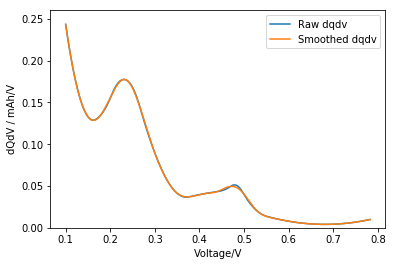

In [32]:
for cycle in [129*2-1]:
    plt.plot(plot_dict[cycle]['Voltage'], plot_dict[cycle]['dqdv'], label='Raw dqdv')
    plt.plot(plot_dict[cycle]['Voltage'], plot_dict[cycle]['Smoothed dqdv'], label='Smoothed dqdv')

plt.ylim(0.0, 0.26)
plt.legend()
plt.xlabel('Voltage/V')
plt.ylabel('dQdV / mAh/V')